<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-текста" data-toc-modified-id="Подготовка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка текста</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучим-модели-и-оценим-их-качество." data-toc-modified-id="Обучим-модели-и-оценим-их-качество.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучим модели и оценим их качество.</a></span><ul class="toc-item"><li><span><a href="#Подготовим-признаки" data-toc-modified-id="Подготовим-признаки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовим признаки</a></span><ul class="toc-item"><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#TF-IDF." data-toc-modified-id="TF-IDF.-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>TF-IDF.</a></span></li><li><span><a href="#Разделим-выборку-на-обучающую-и-тестовую" data-toc-modified-id="Разделим-выборку-на-обучающую-и-тестовую-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Разделим выборку на обучающую и тестовую</a></span></li></ul></li><li><span><a href="#Определим-лучшую-модель" data-toc-modified-id="Определим-лучшую-модель-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Определим лучшую модель</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-Classifier" data-toc-modified-id="Naive-Bayes-Classifier-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span><code>Naive Bayes Classifier</code></a></span></li><li><span><a href="#Linear-Support-Vector-Machine" data-toc-modified-id="Linear-Support-Vector-Machine-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span><code>Linear Support Vector Machine</code></a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span><code>Random Forest Classifier</code></a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span><code>Logistic Regression</code></a></span></li></ul></li><li><span><a href="#Оценим-качество-лучших-моделей-на-тестовой-выборке" data-toc-modified-id="Оценим-качество-лучших-моделей-на-тестовой-выборке-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Оценим качество лучших моделей на тестовой выборке</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [6]:
import pandas as pd
import numpy as np
import string
import re
import scipy.stats as st
import matplotlib.pyplot as plt
import time
import nltk

from tqdm.auto import tqdm, trange

from nltk.stem import *
from nltk.stem import WordNetLemmatizer 
lemmatizing = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = stopwords.words('english')
stop_words.extend(['\n'])

from string import punctuation

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

STATE = 12345

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ialek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info()
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df.duplicated().sum()))
        
def str_corpus(corpus):
    """функция для получения текстовой строки из списка слов"""
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_corpus(data):
    """функция получения списка всех слов в корпусе"""
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

def get_wordCloud(corpus):
    """функция получения облака слов"""
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

def procWordCloud(df):
    """визуализация облака слов"""
    corpus = get_corpus(df.values)
    procWordCloud = get_wordCloud(corpus)
    fig = plt.figure(figsize=(30,30))
    plt.subplot(1, 2, 1)
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.show()
    print('Количество уникальных слов - {}'.format(len(corpus)))
    
def remove_punct(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_punctuation(text):
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return clean_text

def gett_lemm(text):
    text = text.apply(lambda x: word_tokenize(x))
    text = text.apply(lambda x: [w for w in x if not w in stop_words])
    text = text.apply(lambda x: ' '.join([lemmatizing.lemmatize(i, "v") for i in x]))
    return text

Создадим датафрейм для внесения результатов:

- model_name - наименование модели
- f1_score - качество предсказания;

In [6]:
column_names = ['model_name', 'f1_score']
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,model_name,f1_score


In [7]:
def update_results(model_name, f1_score, df_results):
    """функция обновления датафрейма с результатами"""
    result_row_str= [model_name, f1_score]
    rows = [pd.Series(result_row_str, index=df_results.columns)]
    df_results=df_results.append(rows,ignore_index=True)
    return(df_results)

In [8]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')

## Подготовка

In [9]:
review(df)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
Дубликатов не обнаружено


### Подготовка текста

In [10]:
df_for_learning = df.copy(deep=True)

In [11]:
df_for_learning['processed_text'] = df_for_learning['text'].apply(lambda x: remove_punctuation(x.lower()))

In [12]:
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: remove_punct(x))

In [13]:
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: x.split(' '))

In [14]:
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: [token for token in x if token not in stop_words\
                                                                                     and token != " " \
                                                                                     and token.strip()
                                                                                     not in punctuation])

In [15]:
df_for_learning['processed_text'] = df_for_learning['processed_text'].map(lambda x: ' '.join(x))

In [16]:
df_for_learning = df_for_learning.drop_duplicates().reset_index(drop = True)

In [17]:
df_for_learning['text_lemm'] = gett_lemm(df_for_learning['processed_text'])

In [18]:
review(df_for_learning)

,text,toxic,processed_text,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...,make real suggestions improvement wonder secti...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations well use tools well talk,congratulations well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...,vandalism matt shirvington article revert plea...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intending...,sorry word nonsense offensive anyway intend wr...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow,alignment subject contrary dulithgow


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            159571 non-null  object
 1   toxic           159571 non-null  int64 
 2   processed_text  159571 non-null  object
 3   text_lemm       159571 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB
Дубликатов не обнаружено


### Исследовательский анализ

/tmp/ipykernel_143/1795011425.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


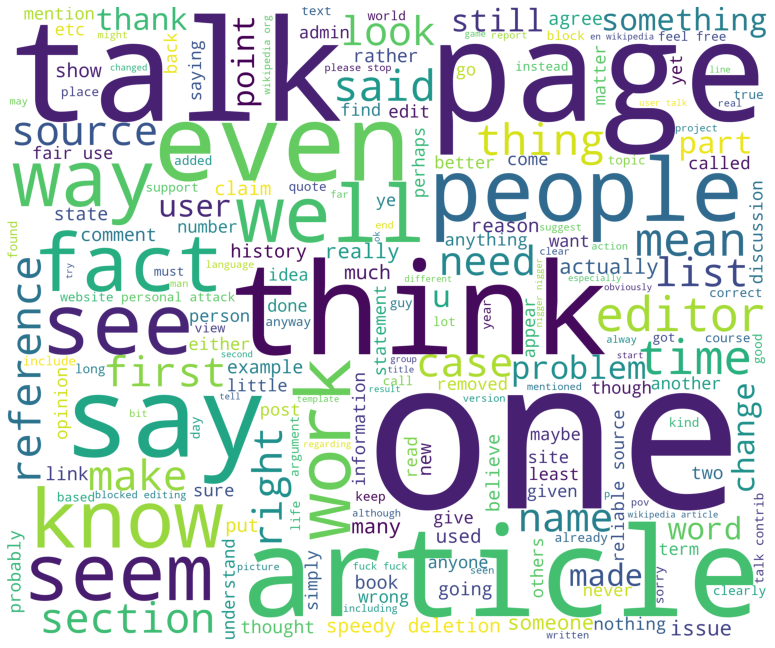

Количество уникальных слов - 5537156


In [68]:
procWordCloud(df_for_learning['processed_text'])

In [69]:
true_toxic = df_for_learning.loc[df['toxic'] == 0]

In [70]:
false_toxic = df_for_learning.loc[df['toxic'] == 1]

/tmp/ipykernel_143/1795011425.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


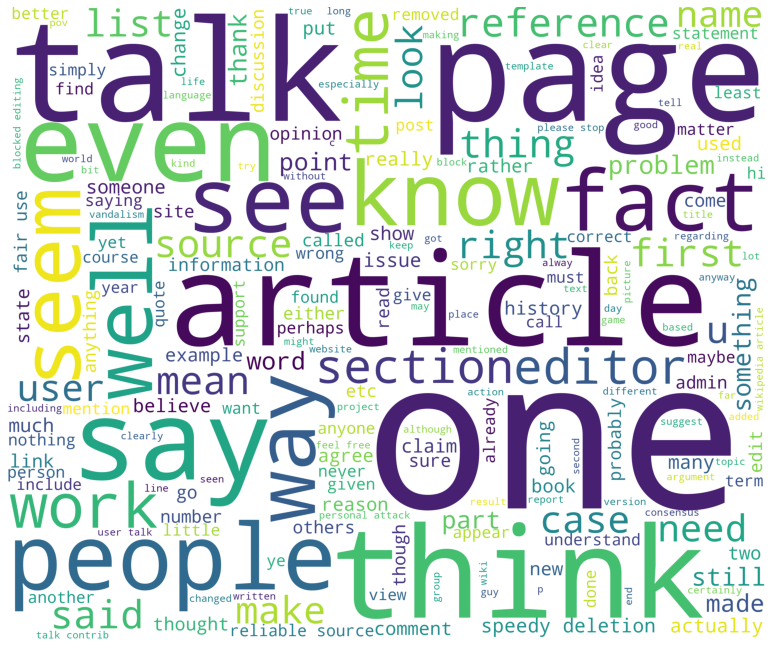

Количество уникальных слов - 5071297


In [71]:
procWordCloud(true_toxic['processed_text'])

/tmp/ipykernel_143/1795011425.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


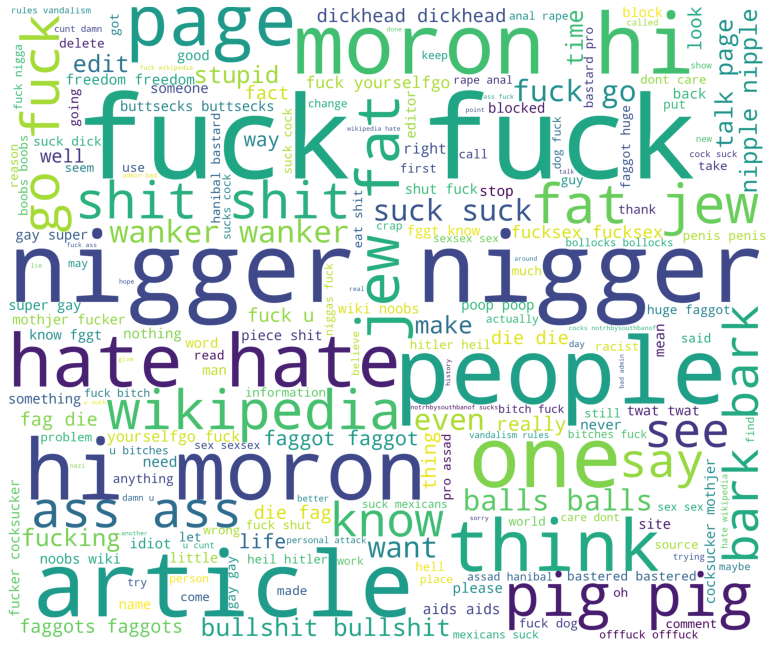

Количество уникальных слов - 465859


In [72]:
procWordCloud(false_toxic['processed_text'])

### Вывод

- для обучения моделей был создан датасет `df_for_learning`, который были скопированы данные из исходной выборки;
- создан столбец `processed_text` на основе данных столбца `text`, где была проведена сл. работа с текстом:
    - данные были приведены к нижнему регистру;
    - данные были очищены от слов паразитов и знаков пунктуации;
    - произведена леммитизация очищенного текста - леммы были внесены в столбец `text_lemm`
- выборка содержит `5537156` уникальных слов;
- позитивные комментарии содержат `5071297` уникальных слова, среди которых выражаются - `talk`, `page`, `people`, `article`, `one`, `even`;
- негативные комментарии содержат `465859` уникальных слова, среди которых выражаются - `fuck`, `moron`, `hate`, `people`, `nigger`, `pig`.

## Обучим модели и оценим их качество.

Для обучения будем использовать сл. алгоритмы:

- `Naive Bayes Classifier`;
- `Linear Support Vector Machine`;
- `Random Forest Classifier`;
- `Logistic Regression`.

Для моделей `Linear Support Vector Machine`, `Random Forest Classifier`, `Logistic Regression` выполним подбор наилучших параметров.

Векторизацию выполним при помощи `Tfidfvectorizer`.

Качество моделей оценим кросс-валидацией с пятью блоками.

In [19]:
def split_data(features, target):
    """функция для формирования обучающей, валидационной и тестовой выборок"""
    (features_train, features_test, target_train, target_test) = train_test_split(features, target, test_size = 0.25, random_state=12345)
    return (features_train, features_test, target_train, target_test)

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=STATE)
    
    return features_downsampled, target_downsampled

### Подготовим признаки

In [21]:
df_for_learning['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Классы несбалансированы - воспользуемся техникой `downsampling`

#### Баланс классов

In [25]:
features = df_for_learning['text_lemm']
target = df_for_learning['toxic']

In [26]:
(features_train, 
 features_test,
 target_train,
 target_test) = split_data(features,
                           target)

In [27]:
features_downsampled, target_downsampled = downsample(features, target, 0.1)

In [28]:
target_downsampled.value_counts()

1    16225
0    14335
Name: toxic, dtype: int64

#### TF-IDF.

In [29]:
tf_idf = TfidfVectorizer(max_features=30000,
                         strip_accents='unicode',
                         analyzer='char',
                         ngram_range=(1,3),
                         use_idf=1,
                         smooth_idf=1,
                         sublinear_tf=1,
                         stop_words = 'english')

In [30]:
features_downsampled = tf_idf.fit_transform(features_downsampled)

#### Разделим выборку на обучающую и тестовую

In [31]:
(features_train, 
 features_test,
 target_train,
 target_test) = split_data(features_downsampled,
                           target_downsampled)

In [32]:
print(features_train.shape)
print(target_train.shape)

(22920, 12623)
(22920,)


In [33]:
print(features_test.shape)
print(target_test.shape)

(7640, 12623)
(7640,)


### Определим лучшую модель

#### `Naive Bayes Classifier`

In [34]:
nbc =  MultinomialNB()

In [35]:
score_nbc = cross_val_score(nbc,
                            features_train,
                            target_train,
                            cv=5,
                            scoring='f1').mean()

In [36]:
df_results = update_results('Naive Bayes Classifier - nbc', score_nbc, df_results)

#### `Linear Support Vector Machine`

In [37]:
sgd = SGDClassifier(penalty='l2', 
                    alpha=1e-3, 
                    random_state=STATE, 
                    max_iter=5, 
                    tol=None)

In [38]:
params_sgd = {'loss':['hinge', 'log', 'modified_huber'],
              'learning_rate':['optimal', 'adaptive'],
              'eta0':[0.1, 0.5]}

In [39]:
grid_sgd = GridSearchCV(sgd, 
                        params_sgd, 
                        scoring='f1',
                        cv=5)

In [40]:
grid_sgd.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(alpha=0.001, max_iter=5,
                                     random_state=12345, tol=None),
             param_grid={'eta0': [0.1, 0.5],
                         'learning_rate': ['optimal', 'adaptive'],
                         'loss': ['hinge', 'log', 'modified_huber']},
             scoring='f1')

In [41]:
grid_sgd.best_params_

{'eta0': 0.1, 'learning_rate': 'optimal', 'loss': 'modified_huber'}

In [42]:
sgd = SGDClassifier(penalty='l2', 
                    alpha=1e-3, 
                    random_state=STATE, 
                    max_iter=5, 
                    tol=None,
                    eta0=0.1,
                    learning_rate='optimal',
                    loss='modified_huber')

In [43]:
df_results = update_results('Linear Support Vector Machine - sgd', grid_sgd.best_score_, df_results)

#### `Random Forest Classifier`

In [44]:
rfc = RandomForestClassifier(n_jobs=-1, 
                             random_state=STATE)

In [45]:
params_rfс = {'n_estimators':[10,30,50], 
              'max_depth':[1,5,10]}

In [46]:
grid_rfc = GridSearchCV(rfc, 
                       params_rfс, 
                       scoring='f1',
                       cv=5)

In [47]:
grid_rfc.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=12345),
             param_grid={'max_depth': [1, 5, 10], 'n_estimators': [10, 30, 50]},
             scoring='f1')

In [48]:
grid_rfc.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [49]:
rfc = RandomForestClassifier(max_depth=10,
                             n_estimators=50,
                             n_jobs=-1, 
                             random_state=STATE)

In [50]:
df_results = update_results('Random Forest Classifier - rfc', grid_rfc.best_score_, df_results)

#### `Logistic Regression`

In [51]:
lr = LogisticRegression(random_state=STATE)

In [52]:
params_lr = {'solver':['newton-cg', 'lbfgs', 'liblinear']}

In [53]:
grid_lr = GridSearchCV(lr, 
                       params_lr, 
                       scoring='f1',
                       cv=5)

In [54]:
grid_lr.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [55]:
grid_lr.best_params_

{'solver': 'newton-cg'}

In [56]:
lr = LogisticRegression(random_state=STATE,
                        solver='newton-cg')

In [57]:
df_results = update_results('Logistic Regression - lr', grid_lr.best_score_, df_results)

### Оценим качество лучших моделей на тестовой выборке 

In [58]:
df_results

,model_name,f1_score
0,Naive Bayes Classifier - nbc,0.835075
1,Linear Support Vector Machine - sgd,0.872680
2,Random Forest Classifier - rfc,0.791031
3,Logistic Regression - lr,0.879192


Все четыре модели показали хороший результат на тренировочной выборке. Качество предсказаний на тестовой выборке оценим двумя наилучшими моделями - `Linear Support Vector Machine - sgd` и `Logistic Regression - lr`

In [59]:
sgd.fit(features_train, target_train)
predicted_test = sgd.predict(features_test)
f1_score_sgd = f1_score(target_test, predicted_test)

In [60]:
lr.fit(features_train, target_train)
predicted_test = lr.predict(features_test)
f1_score_lr = f1_score(target_test, predicted_test)

In [61]:
print('F1 для Linear Support Vector Machine на тестовой выборке: %0.3f' % f1_score_sgd)

F1 для Linear Support Vector Machine на тестовой выборке: 0.875


In [62]:
print('F1 для Logistic Regression на тестовой выборке: %0.3f' % f1_score_lr)

F1 для Logistic Regression на тестовой выборке: 0.884


## Общий вывод

Для обучения моделей текст был обработан сл. образом:
- данные были приведены к нижнему регистру;
- данные были очищены от слов паразитов и знаков пунктуации;
- произведена леммитизация очищенного текста - леммы были внесены в столбец `text_lemm`.

После обработки текста был проведен исследовательский анализ, из чего были сделаны сл. выводы:
- выборка содержит `5537156` уникальных слов;
- позитивные комментарии содержат `5071297` уникальных слова, среди которых выражаются - `talk`, `page`, `people`, `article`, `one`, `even`;
- негативные комментарии содержат `465859` уникальных слова, среди которых выражаются - `fuck`, `moron`, `hate`, `people`, `nigger`, `pig`.

Для обучения использовались сл. алгоритмы:

- `Naive Bayes Classifier`;
- `Linear Support Vector Machine`;
- `Random Forest Classifier`;
- `Logistic Regression`.

При подготовке признаков классы были сбалансированы техникой `downsampling` - далее выборка была разделена на обучающую и тестовую в соотношении 75:25.

Для моделей `Linear Support Vector Machine`, `Random Forest Classifier`, `Logistic Regression` выполнен подбор наилучших параметров.

Векторизация выполнена при помощи `Tfidfvectorizer`.

Качество моделей оценено кросс-валидацией с пятью блоками.

Все четыре модели показали хороший результат на тренировочной выборке. Качество предсказаний на тестовой на наилучших моделях - `Linear Support Vector Machine - sgd` и `Logistic Regression - lr` показало сл. результаты F-меры:
- для Linear Support Vector Machine: `0.875`;
- для Logistic Regression: `0.884`.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны